## DnD Qualitative Examples

In [1]:
# Import libraries

import os
import sys
sys.path.append("..")

import torch
import utils
import data_utils
import DnD_models
import scoring_function

import pandas as pd
import random

from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler

from transformers import BlipProcessor, BlipForConditionalGeneration

### Experiment Settings

In [2]:
# Define variables for dissection

figure = 'fig1a'

settings = {'fig1a': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer1', "ids_to_check": [65, 44]}, 
            'fig1b': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer2', "ids_to_check": [461, 467]},
            'fig1c': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer3', "ids_to_check": [535, 305]},
            'fig1d': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer4', "ids_to_check": [876, 846]},
            'fig3a': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer2', "ids_to_check": [312]},
            'fig3b': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer3', "ids_to_check": [927]},
            'fig6a': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer1', "ids_to_check": [64]},
            'fig6b': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer3', "ids_to_check": [120]},
            'fig9a': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer1', "ids_to_check": [108, 241, 164, 109, 192, 217, 2]},
            'fig9b': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer2', "ids_to_check": [34, 468, 127, 160, 112, 478, 342]},
            'fig10a': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer3', "ids_to_check": [838, 731, 769, 426, 187, 760, 977]},
            'fig10b': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer4', "ids_to_check": [350, 1511, 1369, 345, 1674, 583, 1210]},
            'fig11a': {"d_probe":'imagenet_broden', "target_name":'resnet18_places', "target_layer": 'layer1', "ids_to_check": [19, 38, 2, 18, 9, 26, 42]},
            'fig11b': {"d_probe":'imagenet_broden', "target_name":'resnet18_places', "target_layer": 'layer2', "ids_to_check": [106, 112, 36, 51, 88, 103, 77]},
            'fig12a': {"d_probe":'imagenet_broden', "target_name":'resnet18_places', "target_layer": 'layer3', "ids_to_check": [121, 149, 208, 132, 62, 37, 197]},
            'fig12b': {"d_probe":'imagenet_broden', "target_name":'resnet18_places', "target_layer": 'layer4', "ids_to_check": [209, 478, 305, 243, 348, 331, 42]},
            'fig13': {"d_probe":'imagenet_broden', "target_name":'vit_b_16', "target_layer": 'encoder', "ids_to_check": [185, 325, 522, 746, 226, 457, 410, 625, 363, 122, 82, 507, 665, 727]},
            'fig14a': {"d_probe":'imagenet_broden', "target_name":'resnet152', "target_layer": 'layer1', "ids_to_check": [129, 153, 235]},
            'fig14b': {"d_probe":'imagenet_broden', "target_name":'resnet152', "target_layer": 'layer2', "ids_to_check": [67, 144, 373]},
            'fig14c': {"d_probe":'imagenet_broden', "target_name":'resnet152', "target_layer": 'layer3', "ids_to_check": [301, 500, 766]},
            'fig14d': {"d_probe":'imagenet_broden', "target_name":'resnet152', "target_layer": 'layer4', "ids_to_check": [216, 907, 1732]},
            'fig15a': {"d_probe":'cifar100_train', "target_name":'resnet50', "target_layer": 'layer1', "ids_to_check": [13, 42, 108, 158, 159, 223, 233]},
            'fig15b': {"d_probe":'cifar100_train', "target_name":'resnet50', "target_layer": 'layer2', "ids_to_check": [2, 30, 69, 102, 251, 311, 402]},
            'fig16a': {"d_probe":'cifar100_train', "target_name":'resnet50', "target_layer": 'layer3', "ids_to_check": [65, 177, 202, 231, 384, 657, 847]},
            'fig16b': {"d_probe":'cifar100_train', "target_name":'resnet50', "target_layer": 'layer4', "ids_to_check": [200, 905, 942, 1122, 1725, 1877, 2036]},
            'fig17a': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer1', "ids_to_check": [220, 163]},
            'fig17b': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer2', "ids_to_check": [322, 333]},
            'fig17c': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer3', "ids_to_check": [772, 145]},
            'fig17d': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer4', "ids_to_check": [1417, 24]},
            'fig27a': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer3', "ids_to_check": [106, 193, 515]},
            'fig27b': {"d_probe":'imagenet_broden', "target_name":'resnet50', "target_layer": 'layer4', "ids_to_check": [1880]},
           }

clip_name = 'ViT-B/16'
target_name = settings[figure]["target_name"]
target_layer = settings[figure]["target_layer"]
d_probe = settings[figure]["d_probe"]

batch_size = 200
device = 'cuda'
pool_mode = 'avg'

results_dir = 'exp_results'
saved_acts_dir = 'saved_activations'
num_images_to_check = 10
blip_batch_size = 10
tag = "_"

ids_to_check = settings[figure]["ids_to_check"]

### Load Models

In [3]:
# Load BLIP model

BLIP_PATH = ""

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device) 
pretrained_dict = torch.load(BLIP_PATH)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
model.eval()

/scratch/nbai/job_36758914/ipykernel_99535/3534641851.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(BLIP_PATH)


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [4]:
# Initialize Stable Diffusion

model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))
generator = torch.Generator(device=device).manual_seed(0)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Set Up Results File

In [5]:
# Setting up file/directory paths for saving results
pot_column_names = ['Neuron ID'] + ['Concept {}'.format(i) for i in range(5)]
all_concepts = pd.DataFrame(columns=pot_column_names)
result_column_names = ['Neuron ID', 'Label 1', 'Label 2', 'Label 3']
final_concepts = pd.DataFrame(columns=result_column_names)

In [6]:
# Create results folder
results_path = utils.create_layer_folder(results_dir = results_dir, base_dir = ".", target_name = target_name, 
                          d_probe = d_probe, layer = target_layer, tag = tag)

### Construct Augmented Probing Data (DnD Step 1)

In [7]:
# Get activations
target_save_name = utils.get_save_names(target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  pool_mode=pool_mode, base_dir = '.', saved_acts_dir = saved_acts_dir)

utils.save_activations(target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, batch_size = batch_size, device = device,
                       pool_mode=pool_mode, base_dir = '.', saved_acts_dir = saved_acts_dir)

target_feats = torch.load(target_save_name, map_location='cpu')

pil_data = data_utils.get_data(d_probe)

/scratch/nbai/job_36758914/ipykernel_99535/3116229814.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  target_feats = torch.load(target_save_name, map_location='cpu')


In [8]:
# Find top activating images
top_vals, top_ids = torch.topk(target_feats, k=num_images_to_check, dim=0)

all_imgs = []
all_img_ids = {neuron_id:[] for neuron_id in ids_to_check}

# Find top activating image crops
for t, orig_id in enumerate(ids_to_check):
    print("Cropping for Neuron {}/{}".format(t+1,len(ids_to_check)))
    
    activating_images = []
    for i, top_id in enumerate(top_ids[:, orig_id]):
        
        # Reshape activating images
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        
        # Add image to d_probe with image ID
        all_img_ids[orig_id].append(len(all_imgs))
        all_imgs.append(im)
        activating_images.append(im)
        
    cropped_images = []
    
    # Get crops - FC layers do not have feature maps
    if(target_layer != 'fc'):
        cropped_images = DnD_models.get_attention_crops(target_name, activating_images, orig_id, num_crops_per_image = 4, target_layers = [target_layer], device = device)

    # Add crops into d_probe with image ID
    for img in cropped_images:
        all_img_ids[orig_id].append(len(all_imgs))
        all_imgs.append(img)

Cropping for Neuron 1/2
Cropping for Neuron 2/2


### Generative Captioning (DnD Step 2)

Neuron: 65 (1/2)


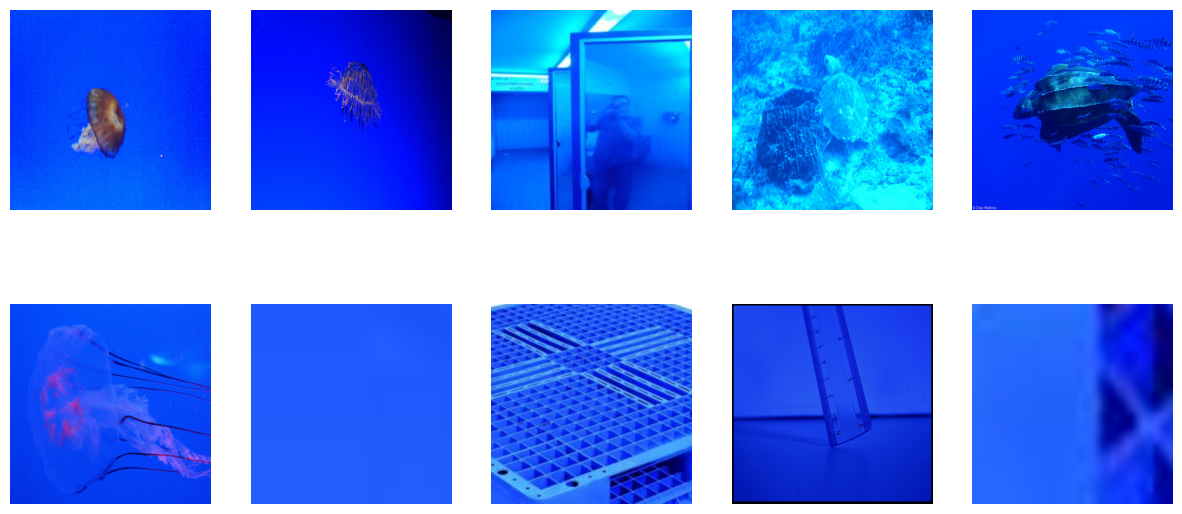

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Image 1 caption: a small animal is laying on a blue surface
Image 2 caption: a jellyfish swimming in a tank
Image 3 caption: a man standing in a blue lit room
Image 4 caption: a fish swimming in the ocean
Image 5 caption: a large group of fish
Image 6 caption: jellyfish in the water
Image 7 caption: a blue background with a white border
Image 8 caption: plastic pald pald pald pald pald pald pald pald pald pald pald pald pald pal
Image 9 caption: a ruler on a blue surface
Image 10 caption: a blue background with a white cross
Candidate Concept 1: Blue-themed visuals
Candidate Concept 2: Blue-themed objects and scenes
Candidate Concept 3: Blue-themed aquatic imagery
Candidate Concept 4: Blue-themed subjects
Candidate Concept 5: Blue-themed objects and scenes
Neuron: 44 (2/2)


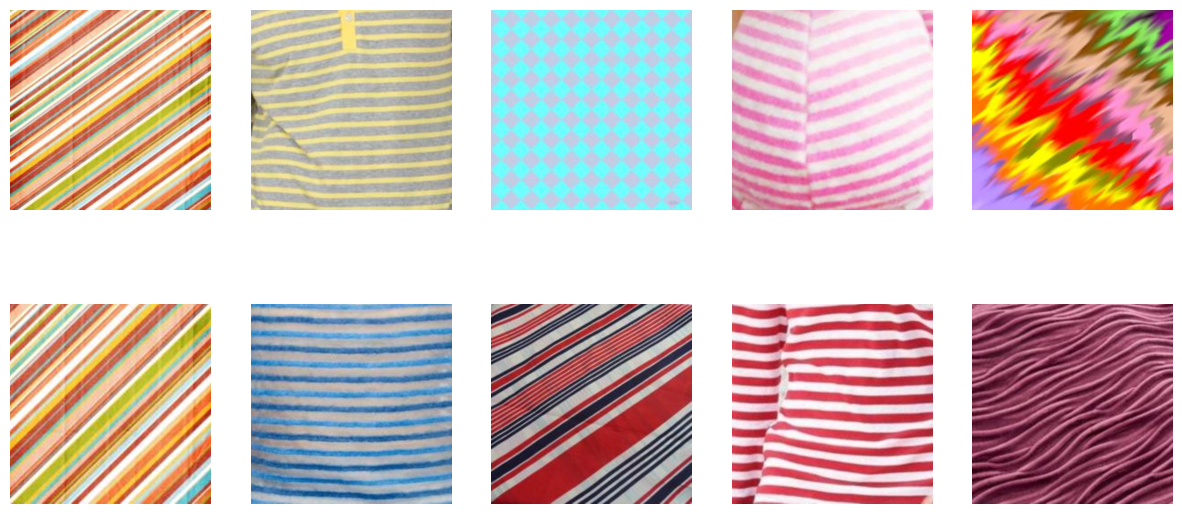

100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Image 1 caption: a colorful striped pattern
Image 2 caption: a man in a yellow and grey striped shirt
Image 3 caption: a blue and pink background with a diamond pattern
Image 4 caption: a stuffed animal with pink and white stripes
Image 5 caption: a colorful abstract background with a pattern
Image 6 caption: a colorful striped pattern
Image 7 caption: a blue and white striped pillow
Image 8 caption: a red and blue striped fabric
Image 9 caption: a little girl wearing a red and white striped shirt
Image 10 caption: a purple blanket with a white background
Candidate Concept 1: Patterned motifs
Candidate Concept 2: Striped Patterns
Candidate Concept 3: Striped and Patterned Textures
Candidate Concept 4: Striped and patterned textures
Candidate Concept 5: Striped and Patterned Textures


In [9]:
# Get target activations with D_probe + D_cropped
target_feats = utils.get_target_activations(target_name, all_imgs, [target_layer])

# Find top activating images
top_vals, top_ids = torch.sort(target_feats, dim=0, descending = True)
comp_words = {orig_id : [] for orig_id in ids_to_check}
top_images = {orig_id:[] for orig_id in ids_to_check}

# Step 2 - Generate Candidate Concepts
for neuron_num, orig_id in enumerate(ids_to_check):
    print("Neuron: {} ({}/{})".format(orig_id, neuron_num+1, len(ids_to_check)))

    # Plot and save highest activating images
    fig, images, top_images = utils.get_top_images(orig_id, top_ids, top_images, 
                                                   all_imgs, all_img_ids, num_images_to_check, 
                                                   blip_batch_size)
    utils.save_activating_fig(fig, results_path, orig_id)
    
    # Generate and simplify BLIP Captions
    descriptions = DnD_models.blip_caption(model, processor, images, blip_batch_size, device)
    for i, description in enumerate(descriptions):
        descriptions[i] = DnD_models.GPT_simplify(description)

    # Summarize BLIP descriptions
    for i in range(5):
        cand_concept = DnD_models.GPT_model_single(descriptions)
        comp_words[orig_id].append(cand_concept)
        random.shuffle(descriptions)
        print("Candidate Concept {}: {}".format(i+1, cand_concept))
    all_concepts.loc[len(all_concepts)] = [orig_id] + comp_words[orig_id]

# Save candidate concepts
utils.save_potential_concepts(all_concepts, results_path)

### Best Concept Selection (DnD Step 3)

In [10]:
"""
We adjust concepts with certain vague words to help SD generation
"""

replace_set = ['design','designs','graphic','graphics']
for orig_id in ids_to_check:
    comp_words[orig_id] = [concept.lower() for concept in comp_words[orig_id]]
    for i, word in enumerate(comp_words[orig_id]):
        if word[-1] == '.':
            comp_words[orig_id][i] = word[:-1]
        if word.split()[-1] in replace_set:
            new_concept = word + ' background'
            comp_words[orig_id].append(new_concept)
    comp_words[orig_id] = list(set(comp_words[orig_id]))

In [11]:
pil_data = data_utils.get_data(d_probe)
d_probe_len = len(pil_data)
all_final_results = {neuron_id : [] for neuron_id in ids_to_check}

num_images_per_prompt = 10
top_K_param = 10
beta_images_param = 5
scoring_func = 'topk-sq-mean'

sd_prompt = 'One realistic image of {}'
num_inference_steps = 50

# Step 3 Main Code
for list_id, orig_id in enumerate(ids_to_check):

    # Initialize starting concepts
    word_list = comp_words[orig_id]
    
    print("Neuron {}".format(orig_id))

    # Account for modified candidate concept (if necessary)
    labels_to_check = len(word_list)

    print("# Labels to Check: {}".format(labels_to_check), "   # Images per Concept: {}".format(num_images_per_prompt))

    add_im = {}
    add_im_id = {}
    all_sd_imgs = []

    # Generate images for each label
    for label_id in range(labels_to_check):
        
        print("Label {}/{}: {}".format(label_id + 1, labels_to_check, word_list[label_id]))
        pred_label = sd_prompt.format(word_list[label_id])
        add_im_id[label_id] = []
        
        add_im, add_im_id, all_sd_imgs = DnD_models.generate_sd_images(add_im, add_im_id, all_sd_imgs, 
                                                                  pred_label, label_id, pipe, generator,
                                                                  num_images_per_prompt, num_inference_steps)
    
    # Concept Scoring
    target_feats = utils.get_target_activations(target_name, all_sd_imgs, [target_layer])
    
    ranks, highest_activating = utils.rank_images(target_feats, orig_id, labels_to_check,
                                                 add_im_id, add_im, top_K_param)
    
    clip_weight = scoring_function.compare_images(top_images[orig_id], highest_activating, clip_name, 
                                                  device, target_name, top_K_param)
    
    top_avg_topk = scoring_function.get_score(ranks, mode = scoring_func, hyp_param = beta_images_param)
    
    top_avg_comb = []
    for i in range(len(clip_weight)):
        concept_rank = len(top_avg_topk) - scoring_function.find_by_last(top_avg_topk, clip_weight[i][1])
        weight = clip_weight[i][0]
        concept_score = concept_rank * weight
        top_avg_comb.append((concept_score, clip_weight[i][1]))
        
    top_avg_comb.sort(reverse = True)
    
    # Save results in .csv file
    for label_num in range(3):
        if(label_num < len(top_avg_comb)):
            all_final_results[orig_id] += [word_list[top_avg_comb[label_num][1]]]
        else:
            all_final_results[orig_id] += [' ']
    final_concepts.loc[len(final_concepts)] = [orig_id] + all_final_results[orig_id]
    
    # Print results
    print('------------------------------\n')
    print('Neuron {}:'.format(orig_id))
    for k, word in enumerate(all_final_results[orig_id]):
        if(word != " "):
            print("Label {}: {}".format(k + 1, word))
        else:
            break
    print('\n------------------------------')
    
utils.save_final_results(final_concepts, results_path)

Neuron 65
# Labels to Check: 4    # Images per Concept: 10
Label 1/4: blue-themed aquatic imagery


  0%|          | 0/50 [00:00<?, ?it/s]

Label 2/4: blue-themed subjects


  0%|          | 0/50 [00:00<?, ?it/s]

Label 3/4: blue-themed objects and scenes


  0%|          | 0/50 [00:00<?, ?it/s]

Label 4/4: blue-themed visuals


  0%|          | 0/50 [00:00<?, ?it/s]

------------------------------

Neuron 65:
Label 1: blue-themed aquatic imagery
Label 2: blue-themed visuals
Label 3: blue-themed subjects

------------------------------
Neuron 44
# Labels to Check: 3    # Images per Concept: 10
Label 1/3: patterned motifs


  0%|          | 0/50 [00:00<?, ?it/s]

Label 2/3: striped patterns


  0%|          | 0/50 [00:00<?, ?it/s]

Label 3/3: striped and patterned textures


  0%|          | 0/50 [00:00<?, ?it/s]

------------------------------

Neuron 44:
Label 1: patterned motifs
Label 2: striped and patterned textures
Label 3: striped patterns

------------------------------
